In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from tqdm import tqdm

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
import re
from deep_translator import GoogleTranslator

In [20]:
df = pd.read_csv('../insta/df_final.csv')

In [24]:
df.shape

(388269, 5)

In [63]:
df = df.dropna()

In [39]:
def tokenize_text(text):
    text = ' '.join(filter(lambda x: not x.startswith('@'), text.split()))
    tokens = word_tokenize(text)
    tokens = [w.lower() for w in tokens]
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    words = [word for word in stripped if word.isalpha()]
    return words

###### Tokenization

In [84]:
subscriptions_tokens = []
for text in tqdm(df.subscription):
    words = tokenize_text(text)
    if len(words) >= 2:
        subscriptions_tokens.append(' '.join(words))
    else:
        subscriptions_tokens.append(np.nan)

  3%|██▍                                                                       | 4658/138880 [00:04<02:05, 1071.12it/s]


KeyboardInterrupt: 

In [16]:
df['subscriptions_tokens'] = subscriptions_tokens

In [17]:
df = df.dropna()

###### cut

In [18]:
user_count = df.groupby('user').location.count()
names = set(user_count[user_count >= 6].index)
df = df[df.apply(lambda x: x.user in names, axis=1)]

In [19]:
df.to_csv('data/data_full.csv', index=False)

In [88]:
df = pd.read_csv('data/data_full.csv')

In [90]:
df = df.sort_values(['user', 'timestamp'])

###### train test split

In [112]:
test_idx = []
for user in tqdm(df.user.unique()):
    df_user = df[df.user == user]
    k = df_user.shape[0]
    k = round(k/3)
    idx = list(df_user[-k:].index)
    test_idx += idx

100%|███████████████████████████████████████████████████████████████████████████| 12894/12894 [01:48<00:00, 118.39it/s]


In [113]:
df_test = df.loc[test_idx]
df_train = df.drop(test_idx)

In [116]:
df_train = df_train.sort_values(['user', 'timestamp'])
df_test = df_test.sort_values(['user', 'timestamp'])

###### translate locations

In [90]:
translator = GoogleTranslator()
locs_tr = dict()
locations = df_train.location.unique()
for loc in tqdm(locations):
    loc_tr = translator.translate(loc)
    locs_tr[loc] = loc_tr

100%|██████████████████████████████████████████████████████████████████████████████| 3133/3133 [11:59<00:00,  4.35it/s]


In [91]:
locations = df_test.location.unique()
for loc in tqdm(locations):
    if loc in locs_tr:
        continue
    loc_tr = translator.translate(loc)
    locs_tr[loc] = loc_tr

100%|██████████████████████████████████████████████████████████████████████████████| 2520/2520 [01:33<00:00, 27.05it/s]


In [93]:
with open('data/locations_translate.json', 'w') as f:
    json.dump(locs_tr, f)

In [ ]:
with open('data/locations_translate.json', 'r') as f:
    locs_tr = json.load(f)

In [94]:
for i in range(df_train.shape[0]):
    loc = df_train.loc[i, 'location']
    df_train.at[i, 'location'] = locs_tr[loc]

In [95]:
for i in range(df_test.shape[0]):
    loc = df_test.loc[i, 'location']
    df_test.at[i, 'location'] = locs_tr[loc]

###### translate train subscriptions

In [4]:
translator = GoogleTranslator()
subs_tr = []
for sub in tqdm(df_train.subscriptions_tokens):
    sub_tr = translator.translate(sub)
    subs_tr.append(sub_tr)

100%|██████████████████████████████████████████████████████████████████████████| 82809/82809 [5:12:34<00:00,  4.42it/s]


In [5]:
df_train['subscriptions_tokens_trans'] = subs_tr

###### top20_tf_idf

In [18]:
sub_sets = df_train.subscriptions_tokens_trans.apply(lambda x: set(x.split())).values
df_dict = dict()
subs_top20_tf_idf = []
for num, sub_set in tqdm(enumerate(sub_sets)):
    sub = df_train.subscriptions_tokens_trans[num].split()
    if len(sub_set) <= 20:
        subs_top20_tf_idf.append(df_train.subscriptions_tokens_trans[num])
        continue
    tokens_tf_idf = dict()
    for token in sub_set:
        tf = sub.count(token)
        df = df_dict.get(token, 0)
        if df == 0:
            for i in sub_sets:
                if token in i:
                    df += 1
            df_dict[token] = df
        tokens_tf_idf[token] = tf/df
    top20_tf_idf_tokens = set(sorted(tokens_tf_idf, key=tokens_tf_idf.get, reverse=True)[:20])
    subs_top20_tf_idf.append(' '.join([token for token in sub if token in top20_tf_idf_tokens]))

82809it [1:14:48, 18.45it/s]


In [64]:
subs_top20_tf_idf_new = []
for text in tqdm(subs_top20_tf_idf):
    words = tokenize_text(text)
    if len(words) == 0:
        subs_top20_tf_idf_new.append(np.nan)
        continue
    subs_top20_tf_idf_new.append(' '.join(set(words)))

100%|██████████████████████████████████████████████████████████████████████████| 82809/82809 [00:20<00:00, 4107.84it/s]


In [65]:
df_train['subscriptions_tokens_trans_top20_new'] = subs_top20_tf_idf_new

In [66]:
df_train = df_train.dropna()

In [67]:
df_train.to_csv('data/data_train.csv', index=False)
df_test.to_csv('data/data_test.csv', index=False)

In [64]:
df_train = pd.read_csv('data/data_train.csv')
df_test = pd.read_csv('data/data_test.csv')

In [67]:
print(len(df_train))
print(len(df_test))

82808
41683


###### set user_count >= 10

In [68]:
from collections import Counter
counter = Counter(df_train.location)
counter.update(Counter(df_test.location))

In [69]:
locations = set()
for loc in counter:
    if counter[loc] >= 5:
        locations.add(loc)
df_train = df_train[df_train.apply(lambda x: x.location in locations, axis=1)]
df_test = df_test[df_test.apply(lambda x: x.location in locations, axis=1)]

In [70]:
user_count = df_train.groupby('user').location.count()
names = set(user_count[user_count >= 6].index)
df_train = df_train[df_train.apply(lambda x: x.user in names, axis=1)]

In [71]:
user_count = df_test.groupby('user').location.count()
names = set(user_count[user_count >= 3].index)
df_test = df_test[df_test.apply(lambda x: x.user in names, axis=1)]

In [74]:
print(len(df_train))
print(len(df_test))

60856
35191


In [78]:
df_train.to_csv('data/data_train_new.csv', index=False)
df_test.to_csv('data/data_test_new.csv', index=False)

###### create context and content

In [79]:
df_train = pd.read_csv('data/data_train_new.csv')
df_test = pd.read_csv('data/data_test_new.csv')

In [80]:
current_user = df_train.user[0]
location = df_train.location[0]
train_context = location
for i in range(1, df_train.shape[0]):
    user = df_train.user[i]
    location = df_train.location[i]
    context = '\t' + location if user == current_user else '\n' + location
    train_context += context
    current_user = user
with open('data/train_context_new.txt', 'w', encoding='utf-8') as f:
    f.write(train_context)

In [81]:
with open('data/train_content_1_new.txt', 'w', encoding='utf-8') as f:
    pass
with open('data/train_content_2_new.txt', 'w', encoding='utf-8') as f:
    pass
for i in tqdm(range(df_train.shape[0])):
    location = df_train.location[i]
    train_content_1 = location + '\t' + df_train.subscriptions_tokens_trans_top20_new[i] + '\n'
    train_content_2 = location + '\t' + '\t'.join(labels_dict[df_train.source[i]]) + '\n'
    with open('data/train_content_1_new.txt', 'a', encoding='utf-8') as f:
        f.write(train_content_1)
    with open('data/train_content_2_new.txt', 'a', encoding='utf-8') as f:
        f.write(train_content_2)

100%|██████████████████████████████████████████████████████████████████████████| 60856/60856 [00:33<00:00, 1798.69it/s]


In [82]:
with open('data/train_content_2_new.txt', 'w', encoding='utf-8') as f:
    pass
for i in tqdm(range(df_train.shape[0])):
    location = df_train.location[i]
    train_content_2 = location + '\t' + '\t'.join(labels_dict_new[df_train.source[i]]) + '\n'
    with open('data/train_content_2_new.txt', 'a', encoding='utf-8') as f:
        f.write(train_content_2)

100%|██████████████████████████████████████████████████████████████████████████| 60856/60856 [00:18<00:00, 3221.76it/s]


In [84]:
current_user = df_test.user[0]
location = df_test.location[0]
test_context = location
for i in range(1, df_test.shape[0]):
    user = df_test.user[i]
    location = df_test.location[i]
    context = '\t' + location if user == current_user else '\n' + location
    test_context += context
    current_user = user
with open('data/test_context_new.txt', 'w', encoding='utf-8') as f:
    f.write(test_context)

In [2]:
df_train = pd.read_csv('data/data_train.csv')
df_test = pd.read_csv('data/data_test.csv')

In [38]:
df_test[:56]

,user,location,source,subscription,timestamp,subscriptions_tokens
0,09_utkarsh,"Szombathely, Hungary",https://scontent-arn2-2.cdninstagram.com/v/t51...,ELTE Szombathely campus📍📚\n.\n.\n.\n.\n.\n.\n....,1.614842e+09,elte szombathely university college student ed...
1,09_utkarsh,"Budapest, Hungary",https://scontent-arn2-1.cdninstagram.com/v/t51...,Don’t shoot what it looks like. Shoot what it ...,1.614844e+09,don t shoot what it looks like shoot what it f...
2,09_utkarsh,"Kőszeg, Hungary",https://scontent-arn2-2.cdninstagram.com/v/t51...,"He - "" you better give me food or you are dead...",1.614929e+09,he you better give me food or you are dead cat...
3,09_utkarsh,"Budapest, Hungary",https://scontent-arn2-2.cdninstagram.com/v/t51...,Live in every moment .......\n.\n.\n.\n.\n.\n....,1.615185e+09,live in every moment streetphotography photogr...
4,0_eeen._.e,"Gyeongsangbuk-do, South Korea",https://scontent-arn2-1.cdninstagram.com/v/t51...,청도와인터널🍅 감이없어서 토매토...\n.\n.\...,1.614801e+09,감이없어서 토매토 청도 청도와인터널 청ᄃ...
5,0_eeen._.e,"Gyeongsangbuk-do, South Korea",https://scontent-frt3-1.cdninstagram.com/v/t51...,이제 두번은 안가겠지...😌\n.\n.\n.\n.\n#청...,1.614801e+09,이제 두번은 안가겠지 청도 청도와인터널...
6,0_eeen._.e,"Gyeongsangbuk-do, South Korea",https://scontent-frt3-1.cdninstagram.com/v/t51...,"와인은 좋지만 감은 넣어두고,,,✨\n.\n.\n...",1.614801e+09,와인은 좋지만 감은 넣어두고 청도 청도...
7,0_eeen._.e,"Daegu, South Korea",https://scontent-frx5-1.cdninstagram.com/v/t51...,날씨 좋구 오프 좋구💕\n.\n.\n.\n.\n#동촌유...,1.615082e+09,날씨 좋구 오프 동촌유원지 대구 아양교 lf...
8,0ivnm0,"Doha, Qatar",https://scontent-arn2-1.cdninstagram.com/v/t51...,#brunch #foodie #travelwithme #flamingo #trave...,1.614851e+09,brunch foodie travelwithme flamingo travellife...
9,0ivnm0,"Doha, Qatar",https://scontent-arn2-1.cdninstagram.com/v/t51...,#doha #qatar #museum #thingstodo #travelwithme...,1.614962e+09,doha qatar museum thingstodo travelwithme trav...


In [15]:
n_checkin = df_train.shape[0] + df_test.shape[0]
n_user = len(set(df_train.user) | set(df_test.user))
print('check-in: {}\nusers: {}'.format(n_checkin, n_user))

check-in: 124491
users: 12894


In [16]:
df = df_train.append(df_test, ignore_index=True)
df

,user,location,source,subscription,timestamp,subscriptions_tokens,subscriptions_tokens_trans,subscriptions_tokens_trans_top20,subscriptions_tokens_trans_top20_new
0,09_utkarsh,"Budapest, Hungary",https://scontent-arn2-1.cdninstagram.com/v/t51...,The only thing we never get enough of is love;...,1.613723e+09,the only thing we never get enough of is love ...,the only thing we never get enough of is love ...,enough enough henry miller igbudapest budapest...,topeuropephoto budapest budapesthungary enough...
1,09_utkarsh,"Szombathely, Hungary",https://scontent-arn2-1.cdninstagram.com/v/t51...,Into the woods 💚\n.\n.\n.\n.\n.\n.\n.\n.\n.\n....,1.614152e+09,into the woods forest nature naturephotography...,into the woods forest nature naturephotography...,into woods forest trees landscape tree hiking ...,tree mountains art into outdoors spring ighung...
2,09_utkarsh,"Miskolc, Hungary",https://scontent-arn2-1.cdninstagram.com/v/t51...,"Lillafüredi vízesés , Miskolc 📍\n.\n.\n.\n.\n....",1.614249e+09,lillafüredi vízesés miskolc longexposure photo...,lillafüredi vízesés miskolc longexposure photo...,lillafüredi vízesés miskolc longexposure ig sh...,discoverhungary longexposurephotography yoursh...
3,09_utkarsh,"Budapest, Hungary",https://scontent-arn2-1.cdninstagram.com/v/t51...,"A good traveler has no fixed plans, and is not...",1.614336e+09,a good traveler has no fixed plans and is not ...,a good traveler has no fixed plans and is not ...,fixed intent arriving lao tzu igbudapest budap...,topeuropephoto lao tram budapesthungary arrivi...
4,09_utkarsh,"Szombathely, Hungary",https://scontent-arn2-1.cdninstagram.com/v/t51...,“It is almost impossible to watch a sunset and...,1.614502e+09,it is almost impossible to watch a sunset and ...,it is almost impossible to watch a sunset and ...,almost impossible watch sunset dream bern will...,yourshotphotographer sunsetphotography sunsetl...
...,...,...,...,...,...,...,...,...,...
124486,zzoeo,San Juan Puerto Rico,https://scontent-hel3-1.cdninstagram.com/v/t51...,Searching for sea glass with my love 🤍,1.614901e+09,searching for sea glass with my love,NaN,NaN,NaN
124487,zzoeo,San Juan Puerto Rico,https://scontent-hel3-1.cdninstagram.com/v/t51...,Really wish I could be at the beach every sing...,1.615773e+09,really wish i could be at the beach every sing...,NaN,NaN,NaN
124488,zzvx_1,"Al Bahah Province, Saudi Arabia",https://scontent-arn2-1.cdninstagram.com/v/t51...,‏وكوب قهوة كفيل بإنعاش روحي🖤\n\n.\n.\n.\n.\n.\...,1.614888e+09,قهوة كفيل بإنعاش up travel ilha paradise saudi...,NaN,NaN,NaN
124489,zzvx_1,"Al Bahah Province, Saudi Arabia",https://scontent-arn2-1.cdninstagram.com/v/t51...,عش بدون ندم من كتاب ابقا قويا\n\n.\n.\n.\n\n.\...,1.614889e+09,عش بدون ندم من كتاب ابقا قويا up travel ilha p...,NaN,NaN,NaN


In [22]:
df.groupby('user').count().location.sum() / n_user

9.654955793392276

In [30]:
user_poi = {}
for i, row in tqdm(df.iterrows()):
    user = row.user
    location = row.location
    if user_poi.get(user) is None:
        user_poi[user] = set((location, ))
    else:
        user_poi[user].add(location)

124491it [00:11, 10825.44it/s]


In [33]:
sum(map(len, user_poi.values())) / len(user_poi)

5.1056305258259655

In [34]:
poi_user = {}
for i, row in tqdm(df.iterrows()):
    user = row.user
    location = row.location
    if poi_user.get(location) is None:
        poi_user[location] = set((user, ))
    else:
        poi_user[location].add(user)

124491it [00:11, 10635.05it/s]


In [36]:
sum(map(len, poi_user.values())) / len(poi_user)

20.425690350605027

In [3]:
labels_link = df_train.source
with open('data/img_labels.json') as f:
    labels_dict = json.load(f)
subs = df_train.subscriptions_tokens_trans_top20_new

In [4]:
words_freq = {}
for i, sub in enumerate(subs):
    for word in sub.split():
        if word not in words_freq:
            words_freq[word] = set((i,))
        else:
            words_freq[word].add(i)

In [5]:
words_freq = {}
for i, link in enumerate(df_train.source):
    labels = labels_dict[link]
    for label in labels:
        if label not in words_freq:
            words_freq[label] = set((i,))
        else:
            words_freq[label].add(i)

In [6]:
sorted(words_freq, key=lambda x: len(words_freq[x]), reverse=True)[:500]

['Sky',
 'Plant',
 'Cloud',
 'Water',
 'Tree',
 'Natural landscape',
 'Building',
 'People in nature',
 'Mountain',
 'Wood',
 'Travel',
 'Azure',
 'Happy',
 'Window',
 'Landscape',
 'Nature',
 'Smile',
 'Blue',
 'Flash photography',
 'Leisure',
 'Water resources',
 'Grass',
 'Daytime',
 'Snow',
 'Lake',
 'Ecoregion',
 'Sunlight',
 'Font',
 'Art',
 'Atmosphere',
 'Street fashion',
 'City',
 'World',
 'Vehicle',
 'Light',
 'Coastal and oceanic landforms',
 'Slope',
 'Sleeve',
 'Highland',
 'Facade',
 'Photograph',
 'Body of water',
 'Branch',
 'Horizon',
 'Dusk',
 'Natural environment',
 'Beach',
 'Gesture',
 'Road surface',
 'Afterglow',
 'Tints and shades',
 'Eyewear',
 'Architecture',
 'Leg',
 'House',
 'Property',
 'Rectangle',
 'Wheel',
 'Sunglasses',
 'Urban design',
 'Tableware',
 'Temple',
 'Tire',
 'Flower',
 'Shoulder',
 'Green',
 'Terrain',
 'Vegetation',
 'Freezing',
 'Food',
 'Leaf',
 'White',
 'Bedrock',
 'Boat',
 'Waist',
 'Vision care',
 'Twig',
 'Table',
 'Tower',
 'Wate

In [111]:
n = 0
jac_sim = 0
arr = sorted(words_freq, key=lambda x: len(words_freq[x]))[:100]
for w1 in tqdm(arr):
    w1 = words_freq[w1]
    for w2 in arr:
        w2 = words_freq[w2]
        jac_sim += len(w1 & w2) / len(w1 | w2)
        n += 1
        
jac_sim/n

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 8326.33it/s]


0.0124

In [110]:
words1 = set(words_freq['Tree'])
words2 = set(words_freq['Wood'])
jac_sim = len(words1 & words2) / len(words1 | words2)
jac_sim

0.1281555483940273

In [113]:
words1 = set(words_freq['Sunlight'])
words2 = set(words_freq['Sleeve'])
jac_sim = len(words1 & words2) / len(words1 | words2)
jac_sim

0.0035366931918656055

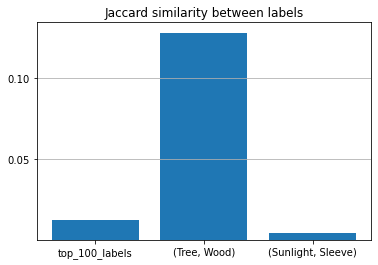

In [11]:
labels = ['top_100_labels', '(Tree, Wood)', '(Sunlight, Sleeve)']
means = [0.012, 0.128, 0.004]

fig, ax = plt.subplots()
ax.bar([0, 1, 2], means)
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(labels)
ax.set_yticks([0.05, 0.1])
ax.grid(axis='y')
plt.title('Jaccard similarity between labels')
plt.show()

In [87]:
labels = ['top_500_words', '(sky, clouds)', '(mountains, bridge)']
means = [0.011, 0.179, 0.004]

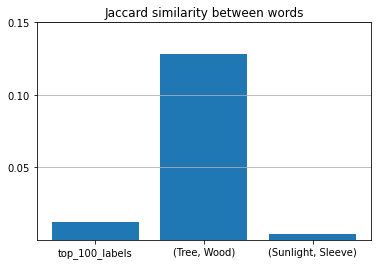

In [12]:
fig, ax = plt.subplots()
ax.bar([0, 1, 2], means)
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(labels)
ax.set_yticks([0.05, 0.1, 0.15])
ax.grid(axis='y')
plt.title('Jaccard similarity between words')
plt.show()